In [1]:
import numpy as np
from model_vanilla_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "/data/scratch/jahanian/mnist_dcgantf_bkup/out_old/shiftx_aug_argminW_lr0.0002_new_aug_75ep/checkpoint"
sample_dir = "/data/scratch/jahanian/mnist_dcgantf_bkup/out_old/shiftx_aug_argminW_lr0.0002_new_aug_75ep/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

shiftx aug is disabled
loading mnist without augmenting ...
Building model_vanilla_shiftx ...
 [*] Reading checkpoints... /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/shiftx_aug_argminW_lr0.0002_new_aug_75ep/checkpoint
INFO:tensorflow:Restoring parameters from /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/shiftx_aug_argminW_lr0.0002_new_aug_75ep/checkpoint/model.b64-81600
 [*] Success to read model.b64-81600


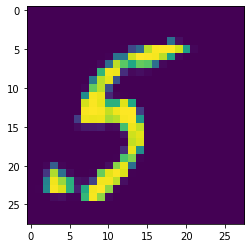

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/walk_train_aug/shiftx_l2_git{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    alpha_val_max = 5
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, alpha_val_max + 1)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-21 18:20:48,821 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.2792189121246338, 0, 0, 0.16066093742847443, 3
2019-09-21 18:20:48,841 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018558740615844727, 0, 10, 0.19028513133525848, -4
2019-09-21 18:20:48,861 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018769025802612305, 0, 20, 0.1217723861336708, 1
2019-09-21 18:20:48,880 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01852583885192871, 0, 30, 0.17558874189853668, -3
2019-09-21 18:20:48,900 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018594026565551758, 0, 40, 0.16653235256671906, 5
2019-09-21 18:20:48,920 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01861858367919922, 0, 50, 0.1543758511543274, -2
2019-09-21 18:20:48,939 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018706560134887695, 0, 60, 0.14659319818019867, -3
2019-09-21 18:20:48,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018541574478149414, 0, 70, 0.1860080063343048, -5
2019-09-21 18:20:48,979 [MainThread

2019-09-21 18:20:50,012 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018282175064086914, 0, 680, 0.14876788854599, 3
2019-09-21 18:20:50,032 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018306732177734375, 0, 690, 0.1658971905708313, -5
2019-09-21 18:20:50,052 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01826930046081543, 0, 700, 0.10379389673471451, 1
2019-09-21 18:20:50,071 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01845574378967285, 0, 710, 0.07321005314588547, -1
2019-09-21 18:20:50,091 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018447160720825195, 0, 720, 0.11290686577558517, 2
2019-09-21 18:20:50,111 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018402814865112305, 0, 730, 0.1564047485589981, 4
2019-09-21 18:20:50,130 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018410921096801758, 0, 740, 0.09341603517532349, 1
2019-09-21 18:20:50,150 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018400907516479492, 0, 750, 0.14049497246742249, -4
2019-09-21 18:20:50,170 [Mai

2019-09-21 18:20:51,243 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00896310806274414, 0, 1350, 0.06904316693544388, -1
2019-09-21 18:20:51,253 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009182453155517578, 0, 1360, 0.14969128370285034, 5
2019-09-21 18:20:51,263 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008990287780761719, 0, 1370, 0.14604416489601135, -5
2019-09-21 18:20:51,273 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009133100509643555, 0, 1380, 0.13597920536994934, 3
2019-09-21 18:20:51,286 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011574983596801758, 0, 1390, 0.16026714444160461, 4
2019-09-21 18:20:51,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010344266891479492, 0, 1400, 0.1193617433309555, 2
2019-09-21 18:20:51,307 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008469104766845703, 0, 1410, 0.13373957574367523, -2
2019-09-21 18:20:51,326 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01723957061767578, 0, 1420, 0.14689704775810242, 5
2019-09-21 18:20

2019-09-21 18:20:52,462 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01863408088684082, 0, 2020, 0.11988804489374161, 2
2019-09-21 18:20:52,481 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856398582458496, 0, 2030, 0.1438966691493988, -3
2019-09-21 18:20:52,501 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018591642379760742, 0, 2040, 0.136673241853714, -5
2019-09-21 18:20:52,518 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01653456687927246, 0, 2050, 0.11653212457895279, -3
2019-09-21 18:20:52,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01874065399169922, 0, 2060, 0.13456328213214874, 5
2019-09-21 18:20:52,566 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.026526927947998047, 0, 2070, 0.15328048169612885, -5
2019-09-21 18:20:52,583 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016417503356933594, 0, 2080, 0.1495298445224762, 5
2019-09-21 18:20:52,601 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016498565673828125, 0, 2090, 0.14125236868858337, 5
2019-09-21 18:20:52,

2019-09-21 18:20:53,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01835012435913086, 0, 2690, 0.05284364894032478, 1
2019-09-21 18:20:53,556 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016713380813598633, 0, 2700, 0.10272987931966782, -4
2019-09-21 18:20:53,573 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016537189483642578, 0, 2710, 0.05640671029686928, 1
2019-09-21 18:20:53,591 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016709327697753906, 0, 2720, 0.14722134172916412, -5
2019-09-21 18:20:53,609 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016598939895629883, 0, 2730, 0.12227001041173935, -3
2019-09-21 18:20:53,628 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018547773361206055, 0, 2740, 0.13937292993068695, -5
2019-09-21 18:20:53,648 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018466472625732422, 0, 2750, 0.10068945586681366, 3
2019-09-21 18:20:53,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016575336456298828, 0, 2760, 0.1314144730567932, 5
2019-09-21 18:

2019-09-21 18:20:54,749 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009936332702636719, 0, 3360, 0.1596962809562683, -5
2019-09-21 18:20:54,757 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007611751556396484, 0, 3370, 0.10894187539815903, 2
2019-09-21 18:20:54,768 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009217500686645508, 0, 3380, 0.1098574548959732, 3
2019-09-21 18:20:54,778 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009313583374023438, 0, 3390, 0.15134619176387787, 5
2019-09-21 18:20:54,790 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011031389236450195, 0, 3400, 0.06547274440526962, 1
2019-09-21 18:20:54,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008751153945922852, 0, 3410, 0.10966981947422028, 3
2019-09-21 18:20:54,811 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009842634201049805, 0, 3420, 0.1384071260690689, -3
2019-09-21 18:20:54,821 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008930683135986328, 0, 3430, 0.05493753030896187, 1
2019-09-21 18:20:

2019-09-21 18:20:55,837 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.024253129959106445, 0, 4020, 0.09212589263916016, -2
2019-09-21 18:20:55,857 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0186460018157959, 0, 4030, 0.1434110850095749, -4
2019-09-21 18:20:55,876 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018759727478027344, 0, 4040, 0.06822793930768967, 1
2019-09-21 18:20:55,902 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.024361133575439453, 0, 4050, 0.13908806443214417, -5
2019-09-21 18:20:55,922 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018659353256225586, 0, 4060, 0.06863505393266678, -1
2019-09-21 18:20:55,941 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018384456634521484, 0, 4070, 0.16186223924160004, 5
2019-09-21 18:20:55,961 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018668651580810547, 0, 4080, 0.10267922282218933, 2
2019-09-21 18:20:55,980 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0186312198638916, 0, 4090, 0.13183718919754028, 4
2019-09-21 18:20:

2019-09-21 18:20:56,952 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01865363121032715, 0, 4690, 0.1382775753736496, -4
2019-09-21 18:20:56,971 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01868128776550293, 0, 4700, 0.10105690360069275, -3
2019-09-21 18:20:56,991 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01873469352722168, 0, 4710, 0.1313447207212448, 5
2019-09-21 18:20:57,011 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01877617835998535, 0, 4720, 0.1303699016571045, -4
2019-09-21 18:20:57,031 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01866745948791504, 0, 4730, 0.0544193871319294, 1
2019-09-21 18:20:57,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018603086471557617, 0, 4740, 0.0792827382683754, 2
2019-09-21 18:20:57,070 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018835783004760742, 0, 4750, 0.1165071427822113, 3
2019-09-21 18:20:57,090 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01879715919494629, 0, 4760, 0.1463584154844284, -5
2019-09-21 18:20:57,108 [

2019-09-21 18:20:58,247 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01868462562561035, 0, 5350, 0.08737830072641373, 2
2019-09-21 18:20:58,267 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018549203872680664, 0, 5360, 0.12544335424900055, 4
2019-09-21 18:20:58,286 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01852703094482422, 0, 5370, 0.13891051709651947, 5
2019-09-21 18:20:58,297 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009929180145263672, 0, 5380, 0.11356274783611298, 3
2019-09-21 18:20:58,307 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008783102035522461, 0, 5390, 0.03961188346147537, -1
2019-09-21 18:20:58,317 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008781909942626953, 0, 5400, 0.07156633585691452, 2
2019-09-21 18:20:58,327 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009399652481079102, 0, 5410, 0.07712960988283157, -2
2019-09-21 18:20:58,337 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008725404739379883, 0, 5420, 0.11715220659971237, -3
2019-09-21 18:2

2019-09-21 18:20:59,383 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018420696258544922, 0, 6010, 0.11999145150184631, -3
2019-09-21 18:20:59,402 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01861882209777832, 0, 6020, 0.11166149377822876, 4
2019-09-21 18:20:59,422 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018671035766601562, 0, 6030, 0.04477541148662567, -1
2019-09-21 18:20:59,442 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01866912841796875, 0, 6040, 0.11164437234401703, 3
2019-09-21 18:20:59,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018588781356811523, 0, 6050, 0.08423880487680435, -2
2019-09-21 18:20:59,481 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018597841262817383, 0, 6060, 0.10669878125190735, 3
2019-09-21 18:20:59,499 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016526460647583008, 0, 6070, 0.08726117759943008, 2
2019-09-21 18:20:59,519 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01868462562561035, 0, 6080, 0.09790560603141785, 3
2019-09-21 18:20

2019-09-21 18:21:00,585 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018563032150268555, 0, 6680, 0.11038847267627716, 4
2019-09-21 18:21:00,605 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018601417541503906, 0, 6690, 0.126027449965477, -4
2019-09-21 18:21:00,625 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01886892318725586, 0, 6700, 0.12081778049468994, 4
2019-09-21 18:21:00,644 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018438339233398438, 0, 6710, 0.09299296140670776, -3
2019-09-21 18:21:00,664 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01836991310119629, 0, 6720, 0.09979922324419022, -4
2019-09-21 18:21:00,683 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018430709838867188, 0, 6730, 0.12827862799167633, 5
2019-09-21 18:21:00,703 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018349885940551758, 0, 6740, 0.09115250408649445, -3
2019-09-21 18:21:00,722 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017918109893798828, 0, 6750, 0.13860145211219788, -5
2019-09-21 18:2

2019-09-21 18:21:01,878 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010066509246826172, 0, 7340, 0.029459062963724136, -1
2019-09-21 18:21:01,888 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008862018585205078, 0, 7350, 0.12565387785434723, 5
2019-09-21 18:21:01,897 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008247852325439453, 0, 7360, 0.06637129187583923, -2
2019-09-21 18:21:01,908 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009062528610229492, 0, 7370, 0.11146222054958344, -4
2019-09-21 18:21:01,917 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008655071258544922, 0, 7380, 0.14193278551101685, -5
2019-09-21 18:21:01,928 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009346723556518555, 0, 7390, 0.024405157193541527, -1
2019-09-21 18:21:01,938 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009499073028564453, 0, 7400, 0.09631434828042984, -4
2019-09-21 18:21:01,948 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009388923645019531, 0, 7410, 0.026979953050613403, -1
2019-0

Loss: [0.013973054520785809, 0.012131180204451085, 0.011347976963967084, 0.011551723588258027, 0.010301829438656568, 0.009537425173446535, 0.008493146194145084, 0.007808973863720894]
2019-09-21 18:21:03,078 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01868414878845215, 0, 8010, 0.05555710941553116, -2
2019-09-21 18:21:03,098 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01810765266418457, 0, 8020, 0.12313016504049301, -5
2019-09-21 18:21:03,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018556833267211914, 0, 8030, 0.09238435328006744, -4
2019-09-21 18:21:03,137 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018474340438842773, 0, 8040, 0.10736041516065598, 4
2019-09-21 18:21:03,157 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018475055694580078, 0, 8050, 0.10729622840881348, 4
2019-09-21 18:21:03,177 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01862049102783203, 0, 8060, 0.0840098038315773, 3
2019-09-21 18:21:03,196 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018536329

2019-09-21 18:21:04,279 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020928621292114258, 0, 8670, 0.034200627356767654, 1
2019-09-21 18:21:04,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018331050872802734, 0, 8680, 0.11862628161907196, 5
2019-09-21 18:21:04,318 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0186312198638916, 0, 8690, 0.05527881160378456, -2
2019-09-21 18:21:04,337 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018543481826782227, 0, 8700, 0.09724315255880356, -3
2019-09-21 18:21:04,357 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018625497817993164, 0, 8710, 0.02900369092822075, 1
2019-09-21 18:21:04,377 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01913142204284668, 0, 8720, 0.025147613137960434, 1
2019-09-21 18:21:04,396 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017880678176879883, 0, 8730, 0.06488575786352158, 3
2019-09-21 18:21:04,416 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856541633605957, 0, 8740, 0.09246188402175903, 4
2019-09-21 18:21

2019-09-21 18:21:05,521 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008443117141723633, 0, 9320, 0.08443553000688553, -3
2019-09-21 18:21:05,531 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008925914764404297, 0, 9330, 0.05559942498803139, -2
2019-09-21 18:21:05,545 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01358795166015625, 0, 9340, 0.10371590405702591, -5
2019-09-21 18:21:05,558 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01141047477722168, 0, 9350, 0.09010165184736252, 4
2019-09-21 18:21:05,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009415149688720703, 0, 9360, 0.04500947892665863, -2
2019-09-21 18:21:05,580 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009656429290771484, 0, 9370, 0.025710368528962135, 1
2019-09-21 18:21:05,590 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009413480758666992, 0, 9380, 0.06847330182790756, 3
2019-09-21 18:21:05,601 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009587764739990234, 0, 9390, 0.0664832815527916, 3
2019-09-21 18:

2019-09-21 18:21:06,772 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019914627075195312, 0, 9990, 0.07361709326505661, 3
2019-09-21 18:21:06,792 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018665075302124023, 0, 10000, 0.06253684312105179, 3
Loss: [0.013973054520785809, 0.012131180204451085, 0.011347976963967084, 0.011551723588258027, 0.010301829438656568, 0.009537425173446535, 0.008493146194145084, 0.007808973863720894, 0.0071467665191739796, 0.006626577673479915]
2019-09-21 18:21:06,812 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01866292953491211, 0, 10010, 0.056832995265722275, -2
2019-09-21 18:21:06,831 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017745018005371094, 0, 10020, 0.05402371659874916, -2
2019-09-21 18:21:06,851 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018579483032226562, 0, 10030, 0.04369505122303963, -2
2019-09-21 18:21:06,870 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01856684684753418, 0, 10040, 0.02624376490712166, 1
2019-09-21 18:21:06,890 [Ma

2019-09-21 18:21:07,890 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018444299697875977, 0, 10640, 0.08496629446744919, 4
2019-09-21 18:21:07,909 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01837778091430664, 0, 10650, 0.05584302544593811, 2
2019-09-21 18:21:07,929 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018076181411743164, 0, 10660, 0.10096464306116104, 5
2019-09-21 18:21:07,948 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01809978485107422, 0, 10670, 0.022306540980935097, 1
2019-09-21 18:21:07,968 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01821756362915039, 0, 10680, 0.10255682468414307, 5
2019-09-21 18:21:07,988 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018318653106689453, 0, 10690, 0.09295117855072021, 5
2019-09-21 18:21:08,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018317699432373047, 0, 10700, 0.09310846030712128, -4
2019-09-21 18:21:08,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018309831619262695, 0, 10710, 0.08854686468839645, 3
2019-09-2

2019-09-21 18:21:09,168 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009653806686401367, 0, 11290, 0.021281400695443153, -1
2019-09-21 18:21:09,178 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008668899536132812, 0, 11300, 0.017747141420841217, 1
2019-09-21 18:21:09,188 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009073495864868164, 0, 11310, 0.09016479551792145, -3
2019-09-21 18:21:09,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011894941329956055, 0, 11320, 0.048549048602581024, -2
2019-09-21 18:21:09,211 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008961915969848633, 0, 11330, 0.09557652473449707, -5
2019-09-21 18:21:09,221 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008908271789550781, 0, 11340, 0.0248283538967371, 1
2019-09-21 18:21:09,232 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009272336959838867, 0, 11350, 0.09794580936431885, 5
2019-09-21 18:21:09,242 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009286165237426758, 0, 11360, 0.08495359867811203, -4
2

2019-09-21 18:21:10,256 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016550302505493164, 0, 11950, 0.12257033586502075, -5
2019-09-21 18:21:10,274 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016569137573242188, 0, 11960, 0.0193294957280159, -1
2019-09-21 18:21:10,289 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014513731002807617, 0, 11970, 0.10540349036455154, -5
2019-09-21 18:21:10,307 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016741514205932617, 0, 11980, 0.07144515216350555, 3
2019-09-21 18:21:10,325 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016504526138305664, 0, 11990, 0.023348841816186905, -1
2019-09-21 18:21:10,342 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016468524932861328, 0, 12000, 0.08122073858976364, -4
Loss: [0.013973054520785809, 0.012131180204451085, 0.011347976963967084, 0.011551723588258027, 0.010301829438656568, 0.009537425173446535, 0.008493146194145084, 0.007808973863720894, 0.0071467665191739796, 0.006626577673479915, 0.007125782011076808, 0

2019-09-21 18:21:11,323 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016557693481445312, 0, 12590, 0.10284750163555145, 5
2019-09-21 18:21:11,341 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016611337661743164, 0, 12600, 0.07828830182552338, -4
2019-09-21 18:21:11,358 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016611337661743164, 0, 12610, 0.04654591903090477, 2
2019-09-21 18:21:11,376 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016649484634399414, 0, 12620, 0.01580396480858326, -1
2019-09-21 18:21:11,394 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01666402816772461, 0, 12630, 0.017451263964176178, 1
2019-09-21 18:21:11,411 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016804933547973633, 0, 12640, 0.038131244480609894, -2
2019-09-21 18:21:11,431 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018461227416992188, 0, 12650, 0.01864597387611866, 1
2019-09-21 18:21:11,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018896818161010742, 0, 12660, 0.021973101422190666, -1
20

2019-09-21 18:21:12,543 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02092289924621582, 0, 13230, 0.09865163266658783, 5
2019-09-21 18:21:12,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018241167068481445, 0, 13240, 0.06661289185285568, -3
2019-09-21 18:21:12,580 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016466856002807617, 0, 13250, 0.067546546459198, -3
2019-09-21 18:21:12,600 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018596887588500977, 0, 13260, 0.10297641903162003, -5
2019-09-21 18:21:12,619 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01862502098083496, 0, 13270, 0.06402494758367538, -3
2019-09-21 18:21:12,639 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018631458282470703, 0, 13280, 0.01872774213552475, -1
2019-09-21 18:21:12,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018634319305419922, 0, 13290, 0.07975955307483673, -3
2019-09-21 18:21:12,678 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018643617630004883, 0, 13300, 0.025689786300063133, -1
2019

2019-09-21 18:21:13,726 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018676280975341797, 0, 13890, 0.04020342230796814, -2
2019-09-21 18:21:13,746 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018466949462890625, 0, 13900, 0.0756765604019165, -5
2019-09-21 18:21:13,766 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018483877182006836, 0, 13910, 0.034546781331300735, -2
2019-09-21 18:21:13,785 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018525362014770508, 0, 13920, 0.05889180302619934, 2
2019-09-21 18:21:13,805 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018568754196166992, 0, 13930, 0.10680164396762848, -4
2019-09-21 18:21:13,824 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018590927124023438, 0, 13940, 0.05278850346803665, -2
2019-09-21 18:21:13,844 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01837301254272461, 0, 13950, 0.022854909300804138, 1
2019-09-21 18:21:13,864 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018655061721801758, 0, 13960, 0.0661633089184761, 3
2019

2019-09-21 18:21:14,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014425992965698242, 0, 14530, 0.09583943337202072, -5
2019-09-21 18:21:14,877 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016570329666137695, 0, 14540, 0.03497600927948952, 2
2019-09-21 18:21:14,897 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01847553253173828, 0, 14550, 0.02356593683362007, -1
2019-09-21 18:21:14,916 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01852107048034668, 0, 14560, 0.02212066575884819, -1
2019-09-21 18:21:14,936 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018398046493530273, 0, 14570, 0.10188324004411697, 5
2019-09-21 18:21:14,958 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020911455154418945, 0, 14580, 0.016658376902341843, 1
2019-09-21 18:21:14,977 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01841282844543457, 0, 14590, 0.021920839324593544, -1
2019-09-21 18:21:14,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01861739158630371, 0, 14600, 0.08204435557126999, 3
2019-0

2019-09-21 18:21:16,110 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01870584487915039, 0, 15170, 0.040564827620983124, 2
2019-09-21 18:21:16,130 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018732070922851562, 0, 15180, 0.08330763131380081, -4
2019-09-21 18:21:16,150 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018588542938232422, 0, 15190, 0.08942248672246933, -5
2019-09-21 18:21:16,169 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018605947494506836, 0, 15200, 0.09563666582107544, 5
2019-09-21 18:21:16,189 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0186922550201416, 0, 15210, 0.08502793312072754, -4
2019-09-21 18:21:16,209 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018677949905395508, 0, 15220, 0.018425388261675835, 1
2019-09-21 18:21:16,228 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0185849666595459, 0, 15230, 0.08847185969352722, 5
2019-09-21 18:21:16,248 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018359661102294922, 0, 15240, 0.09148755669593811, -5
2019-09

2019-09-21 18:21:17,281 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018664121627807617, 0, 15830, 0.06665126979351044, -3
2019-09-21 18:21:17,303 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021012544631958008, 0, 15840, 0.09404173493385315, 5
2019-09-21 18:21:17,323 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018343687057495117, 0, 15850, 0.021496012806892395, 1
2019-09-21 18:21:17,342 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018427133560180664, 0, 15860, 0.103703573346138, -4
2019-09-21 18:21:17,362 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018291711807250977, 0, 15870, 0.021748920902609825, -1
2019-09-21 18:21:17,381 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0185701847076416, 0, 15880, 0.02467157319188118, 1
2019-09-21 18:21:17,401 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0186159610748291, 0, 15890, 0.0451493039727211, 2
2019-09-21 18:21:17,423 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02048516273498535, 0, 15900, 0.09269215911626816, 4
2019-09-21 

2019-09-21 18:21:18,480 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008989095687866211, 0, 16470, 0.06704256683588028, 3
2019-09-21 18:21:18,490 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008973121643066406, 0, 16480, 0.025628402829170227, 1
2019-09-21 18:21:18,500 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009159326553344727, 0, 16490, 0.10184431821107864, 4
2019-09-21 18:21:18,511 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009313344955444336, 0, 16500, 0.041079241782426834, -2
2019-09-21 18:21:18,521 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009089231491088867, 0, 16510, 0.023325175046920776, -1
2019-09-21 18:21:18,531 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009218454360961914, 0, 16520, 0.0349862277507782, -2
2019-09-21 18:21:18,541 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009026765823364258, 0, 16530, 0.019320618361234665, -1
2019-09-21 18:21:18,554 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011401891708374023, 0, 16540, 0.02133958227932453, -1


2019-09-21 18:21:19,629 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853775978088379, 0, 17100, 0.0636395588517189, -4
2019-09-21 18:21:19,648 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01854872703552246, 0, 17110, 0.05460019037127495, 3
2019-09-21 18:21:19,668 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018185138702392578, 0, 17120, 0.0188282523304224, 1
2019-09-21 18:21:19,688 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018518447875976562, 0, 17130, 0.04693024232983589, -2
2019-09-21 18:21:19,707 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018541336059570312, 0, 17140, 0.07813620567321777, 5
2019-09-21 18:21:19,727 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018660783767700195, 0, 17150, 0.09698183834552765, 5
2019-09-21 18:21:19,747 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018374204635620117, 0, 17160, 0.11181916296482086, 5
2019-09-21 18:21:19,766 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018517494201660156, 0, 17170, 0.08870621025562286, 4
2019-09-21

2019-09-21 18:21:20,781 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0184478759765625, 0, 17760, 0.09086647629737854, -4
2019-09-21 18:21:20,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018553733825683594, 0, 17770, 0.09001687914133072, 3
2019-09-21 18:21:20,820 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018541336059570312, 0, 17780, 0.0838540568947792, 4
2019-09-21 18:21:20,840 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01859259605407715, 0, 17790, 0.10857381671667099, -5
2019-09-21 18:21:20,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018604040145874023, 0, 17800, 0.022456901147961617, -1
2019-09-21 18:21:20,879 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01857137680053711, 0, 17810, 0.040804699063301086, 2
2019-09-21 18:21:20,898 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01853203773498535, 0, 17820, 0.08295455574989319, -5
2019-09-21 18:21:20,918 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018472909927368164, 0, 17830, 0.030450919643044472, -1
2019-0

2019-09-21 18:21:22,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015126228332519531, 0, 18390, 0.01926756650209427, -1
2019-09-21 18:21:22,040 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008247613906860352, 0, 18400, 0.10377665609121323, 5
2019-09-21 18:21:22,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00841665267944336, 0, 18410, 0.04084320738911629, -2
2019-09-21 18:21:22,060 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009021520614624023, 0, 18420, 0.01771591231226921, 1
2019-09-21 18:21:22,070 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008626937866210938, 0, 18430, 0.02247968316078186, -1
2019-09-21 18:21:22,078 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007843017578125, 0, 18440, 0.020860016345977783, -1
2019-09-21 18:21:22,089 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009103059768676758, 0, 18450, 0.01779303140938282, -1
2019-09-21 18:21:22,101 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011118888854980469, 0, 18460, 0.10421136021614075, 4
2019-0

2019-09-21 18:21:23,134 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01854538917541504, 0, 19020, 0.0690346360206604, 3
2019-09-21 18:21:23,154 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01870131492614746, 0, 19030, 0.09483946114778519, -5
2019-09-21 18:21:23,173 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018264055252075195, 0, 19040, 0.01819824054837227, 1
2019-09-21 18:21:23,193 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018314838409423828, 0, 19050, 0.023044724017381668, 1
2019-09-21 18:21:23,212 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01807379722595215, 0, 19060, 0.06036270409822464, -3
2019-09-21 18:21:23,232 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0180361270904541, 0, 19070, 0.04689808189868927, -2
2019-09-21 18:21:23,252 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01836371421813965, 0, 19080, 0.1041974350810051, -5
2019-09-21 18:21:23,271 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01818561553955078, 0, 19090, 0.04458386078476906, -2
2019-09-21 

2019-09-21 18:21:24,346 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018604755401611328, 0, 19680, 0.10719086974859238, 4
2019-09-21 18:21:24,365 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018432140350341797, 0, 19690, 0.045217692852020264, 2
2019-09-21 18:21:24,385 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018586158752441406, 0, 19700, 0.023885976523160934, -1
2019-09-21 18:21:24,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018428325653076172, 0, 19710, 0.08866254985332489, -5
2019-09-21 18:21:24,424 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018554210662841797, 0, 19720, 0.07452310621738434, 3
2019-09-21 18:21:24,444 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018375158309936523, 0, 19730, 0.034499313682317734, -2
2019-09-21 18:21:24,464 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018489360809326172, 0, 19740, 0.07572060823440552, -3
2019-09-21 18:21:24,483 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01854729652404785, 0, 19750, 0.014264046214520931, -1


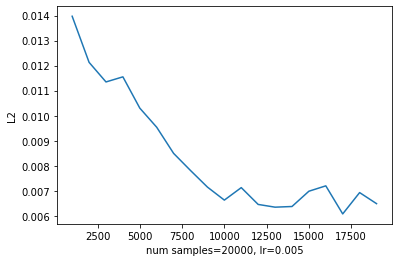

[0.013973054520785809, 0.012131180204451085, 0.011347976963967084, 0.011551723588258027, 0.010301829438656568, 0.009537425173446535, 0.008493146194145084, 0.007808973863720894, 0.0071467665191739796, 0.006626577673479915, 0.007125782011076808, 0.0064539026506245135, 0.006344522510655225, 0.00637124128267169, 0.006981964196078479, 0.007196535003371537, 0.006075052754953503, 0.006927239494398236, 0.00648548030667007]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/walk_train_aug/shiftx_l2_git0.005/output/model_20000.ckpt")

[-8 -6 -5 -4 -2  0  2  4  5  6  8]


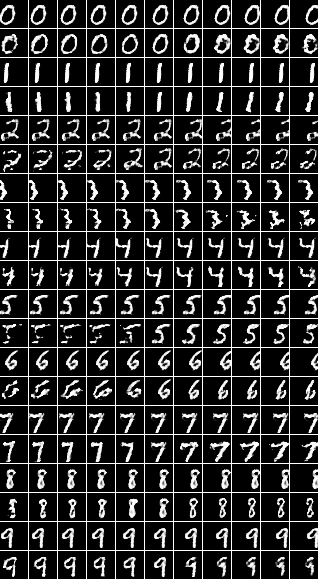

In [21]:
num_samples = 10
# a = np.array([-15, -12, -9, -6, -3,  0,  3,  6,  9, 12, 15])
a = np.array([-8, -6, -5, -4, -2,  0,  2,  4,  5, 6,  8])

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [22]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [23]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained
# dist_trained_tensor = loss_l2_sample
# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [24]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [25]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -7.00, dist 0.03 +/- 0.02
alpha: -5.50, dist 0.01 +/- 0.01
alpha: -4.50, dist 0.02 +/- 0.01
alpha: -3.00, dist 0.05 +/- 0.03
alpha: -1.00, dist 0.06 +/- 0.03
alpha: 1.00, dist 0.06 +/- 0.03
alpha: 3.00, dist 0.05 +/- 0.03
alpha: 4.50, dist 0.02 +/- 0.01
alpha: 5.50, dist 0.01 +/- 0.01
alpha: 7.00, dist 0.03 +/- 0.02
2019-09-21 18:31:13,591 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-21 18:31:13,593 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


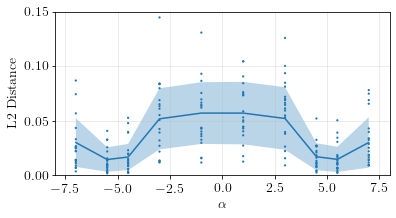

In [26]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/plots/'
savefile = 'shiftx_aug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [31]:
dist_trained_joint = np.load("./out/plots/dist_trained_info_shiftx_aug_argminGW_loss_trained_plots_75epoch.npy")
dist_trained_NoAug_argminGW = np.load("./out/plots/dist_trained_info_shiftx_NoAug_argminGW_loss_trained_plots_75epoch.npy")
dist_trained_NoAug_argminW = np.load("./out/plots/dist_trained_info_shiftx_NoAug_argminW_loss_trained_plots_75epoch.npy")

alpha: -8.00, dist 0.16 +/- 0.01
alpha: -6.00, dist 0.13 +/- 0.01
alpha: -5.00, dist 0.11 +/- 0.01
alpha: -4.00, dist 0.09 +/- 0.01
alpha: -2.00, dist 0.05 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 2.00, dist 0.05 +/- 0.01
alpha: 4.00, dist 0.09 +/- 0.01
alpha: 5.00, dist 0.11 +/- 0.01
alpha: 6.00, dist 0.12 +/- 0.01
alpha: 8.00, dist 0.15 +/- 0.01


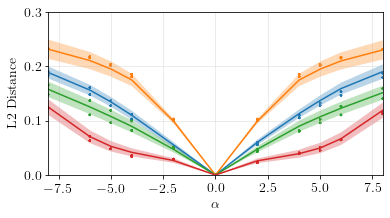

In [35]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/plots/'
savefile = 'shiftx_aug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)


### For noaug + walk
mu_j = np.mean(dist_trained_NoAug_argminW, axis=0)
sd_j = np.std(dist_trained_NoAug_argminW, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_NoAug_argminW[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

### For noaug + joint
mu_j = np.mean(dist_trained_NoAug_argminGW, axis=0)
sd_j = np.std(dist_trained_NoAug_argminGW, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_NoAug_argminGW[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

### For shift aug+walk (this file)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
### For shift join
mu_j = np.mean(dist_trained_joint, axis=0)
sd_j = np.std(dist_trained_joint, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_joint[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [33]:
np.save("./out/plots/dist_info_shiftx_aug_argminW_transform_effect_plots_75epoch.npy", dist_info)
np.save("./out/plots/dist_trained_info_shiftx_aug_argminW_loss_trained_plots_75epoch.npy", dist_trained_info)